# **In this project we are trying to predict whether a patient has or not diabtes given certain characteristics**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import pickle

In [3]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Diabetes-prediction/diabetes_prediction_dataset.csv"

df = pd.read_csv(dataset_path)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.shape

(100000, 9)

# Handling null values

In [5]:
df["smoking_history"].value_counts()

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

In [6]:
# Dropping values where we have "No Info"
df = df[df["smoking_history"] != "No Info"]

In [7]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

The is no need to handle null values

# Detection and removal of outliers

We are going to detect extreme cases and remove them by using 1 standard deviation, also we fit the "bmi" feature into a gaussian distribution

In [8]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,64184.000000,64184.000000,64184.000000,64184.000000,64184.000000,64184.000000,64184.000000
mean,46.544112,0.097890,0.047037,28.424120,5.564281,139.628225,0.109778
std,19.540334,0.297169,0.211719,6.516199,1.095519,42.165904,0.312615
min,0.160000,0.000000,0.000000,10.080000,3.500000,80.000000,0.000000
25%,31.000000,0.000000,0.000000,24.600000,4.800000,100.000000,0.000000
50%,47.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,61.000000,0.000000,0.000000,31.100000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,91.820000,9.000000,300.000000,1.000000


Coefficient of skewness: 1.26


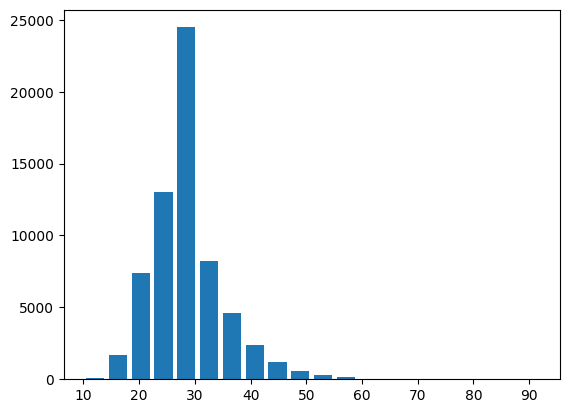

In [9]:
skewness = skew(df["bmi"])
print(f"Coefficient of skewness: {round(skewness, 2)}")
plt.hist(df["bmi"], bins=20, rwidth=0.8)
plt.show()

As we can see, the bmi feature does now follows a gaussian distribussion, showing a positive skew demostrated with the coefficient of skewness. In order to transform it, we will apply:

In [10]:
df["bmi"] = np.log(df["bmi"])

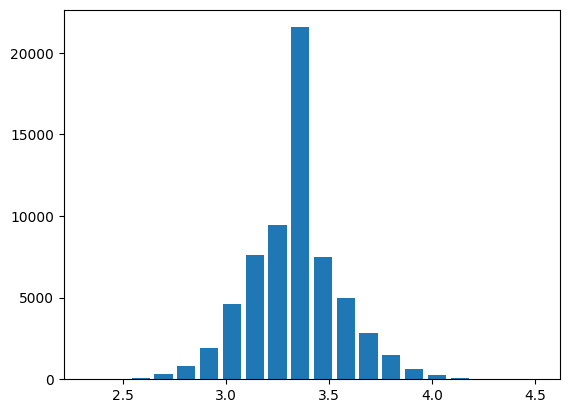

In [11]:
# Fitted feature with normal distribution
plt.hist(df["bmi"], bins=20, rwidth=0.8)
plt.show()

In [12]:
skewness = skew(df["bmi"])
print(f"Coefficient of skewness: {round(skewness, 2)}")

Coefficient of skewness: 0.24


In [13]:
# This function removes outliers given the standard deviation of the feature (bmi)
def remove_outliers(df, feature):
  new_df = pd.DataFrame()

  mean = np.mean(df[feature])
  sd = np.std(df[feature])
  red_df = df[(df[feature]>(mean - sd)) & (df[feature]<=(mean + sd))]
  new_df = pd.concat([new_df, red_df], ignore_index=True)

  return new_df

In [14]:
dfx = remove_outliers(df, "bmi")
dfx.shape

(45613, 9)

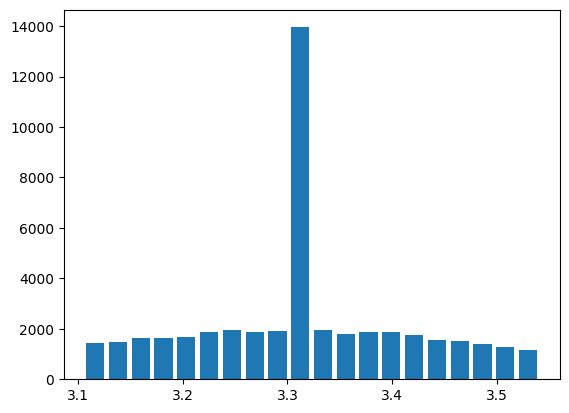

In [15]:
plt.hist(dfx["bmi"], bins=20, rwidth=0.8)
plt.show()

#Transforming string values into numeric values, performing one hot encoding

In [16]:
print(f"Shape: {df.shape}")
df.head()

Shape: (64184, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,3.226447,6.6,140,0
2,Male,28.0,0,0,never,3.307619,5.7,158,0
3,Female,36.0,0,0,current,3.154870,5.0,155,0
4,Male,76.0,1,1,current,3.002708,4.8,155,0
5,Female,20.0,0,0,never,3.307619,6.6,85,0


In [17]:
sex_dummies = pd.get_dummies(df["gender"])
smk_dummies = pd.get_dummies(df["smoking_history"])
# Dropping a column to have n-1 dummie variables and prevent multicollinearity
sex_dummies = sex_dummies.drop(["Other"], axis="columns")
smk_dummies = smk_dummies.drop(["current"], axis="columns")
sex_dummies.head()

,Female,Male
0,1,0
2,0,1
3,1,0
4,0,1
5,1,0


In [18]:
df2 = pd.concat([df, sex_dummies, smk_dummies], axis="columns")
df2 = df2.drop(["gender", "smoking_history"], axis = "columns")
df2

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,ever,former,never,not current
0,80.0,0,1,3.226447,6.6,140,0,1,0,0,0,1,0
2,28.0,0,0,3.307619,5.7,158,0,0,1,0,0,1,0
3,36.0,0,0,3.154870,5.0,155,0,1,0,0,0,0,0
4,76.0,1,1,3.002708,4.8,155,0,0,1,0,0,0,0
5,20.0,0,0,3.307619,6.6,85,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,26.0,0,0,3.536311,6.5,160,0,1,0,0,0,1,0
99993,40.0,0,0,3.705982,3.5,155,0,1,0,0,0,1,0
99997,66.0,0,0,3.326115,5.7,155,0,0,1,0,1,0,0
99998,24.0,0,0,3.567277,4.0,100,0,1,0,0,0,1,0


In [19]:
X = df2.drop(["diabetes"], axis="columns")
y = df2["diabetes"]
y.value_counts()

0    57138
1     7046
Name: diabetes, dtype: int64

# **Model building**

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [21]:
rfc_ = RandomForestClassifier()
rfc_.fit(X_train, y_train)
rfc_.score(X_test, y_test)

0.9592583937056944

In [22]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cross_val_score(rfc_, X, y, cv=cv)

array([0.95925839, 0.96346498, 0.9579341 , 0.96424398, 0.96042689,
       0.96120589, 0.96253019, 0.96027109, 0.96284179, 0.96097219])

In [23]:
def best_model(X, y):
  algos = {
      "KNeighborsClassifier": {
          "model": KNeighborsClassifier(),
          "params": {
              "n_neighbors": [5, 8, 10],
              "weights": ["uniform", "distance"],
              "p": [1, 2]
          }
      },
      "Random Forest Classifier": {
          "model": RandomForestClassifier(),
          "params": {
              "n_estimators": [10, 30, 50, 70, 100],
              "criterion": ["gini", "entropy"],
              "max_depth": [9, 12, 15, None]
          }
      },
      "XGBoost": {
          "model": xgb.XGBClassifier(),
          "params": {
              "eta": [0.3, 0.1, 0.01],
              "max_depth": [6, 9, 12],

          }
      }

  }
  scores = []
  cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

  for alg_name, conf in algos.items():
    gs = GridSearchCV(conf["model"], conf["params"], cv=cv)
    gs.fit(X,y)
    scores.append({
        "model": alg_name,
        "best_score": gs.best_score_,
        "best_params": gs.best_params_
    })
  return pd.DataFrame(scores, columns=["model", "best_score", "best_params"])

In [24]:
# Hyperparameter tuning
df_models = best_model(X, y)

In [25]:
df_models

,model,best_score,best_params
0,KNeighborsClassifier,0.947605,"{'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}"
1,Random Forest Classifier,0.963777,"{'criterion': 'entropy', 'max_depth': 12, 'n_e..."
2,XGBoost,0.963730,"{'eta': 0.1, 'max_depth': 9}"


In [36]:
# Best performing model shown in the hyperparameter tuning, always is Random Forest Classifier
rfc = RandomForestClassifier(
    criterion = df_models["best_params"][1]["criterion"],
    max_depth = df_models["best_params"][1]["max_depth"],
    n_estimators = df_models["best_params"][1]["n_estimators"]
)
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=30)

In [37]:
def make_prediction(age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_level, gender, smoking_history):
  gender_index = np.where(X.columns==gender)[0][0]
  smoke_index = np.where(X.columns==smoking_history)[0][0]

  x = np.zeros(len(X.columns))
  x[0] = age
  x[1] = hypertension
  x[2] = heart_disease
  x[3] = np.log(bmi)
  x[4] = HbA1c_level
  x[5] = blood_glucose_level
  if gender_index >= 0:
    x[gender_index] = 1
  if smoke_index >= 0:
    x[smoke_index] = 1

  return rfc.predict([x])[0]

In [38]:
make_prediction(56, 0, 0, 89, 6.5, 140, "Male", "former")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0

In [39]:
with open("diabetes_prediction.pickle", "wb") as f:
  pickle.dump(rfc, f)

In [ ]:
import json
columns = {
    "data_columns": [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f:
  f.write(json.dumps(columns))